In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
from torchvision import transforms,datasets,models
import numpy
import fc_loader
from torch import nn
import torch.nn.functional as F
import helper

In [0]:
transform = transforms.Compose([transforms.Resize((255,255)),
                               transforms.CenterCrop((224,224)),
                               transforms.ToTensor()])
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

train_dataset=datasets.ImageFolder("Cat_Dog_data/train",transform=train_transforms)
test_dataset=datasets.ImageFolder("Cat_Dog_data/test",transform=transform)

trainloader=torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)
testloader=torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True)


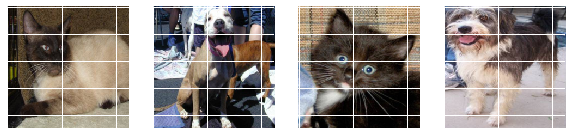

In [3]:
data_iter = iter(testloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax, normalize=False)

In [4]:
torch.cuda.is_available()

True

In [5]:
model = models.densenet121(pretrained=True)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:01<00:00, 29196874.24it/s]


In [0]:
print(model)

In [0]:
for param in model.parameters():
    param.requires_grad=False

In [0]:
from collections import OrderedDict

classifier=nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

In [0]:
model.classifier=classifier

In [0]:
criterion = nn.NLLLoss()
optimizer=torch.optim.Adam(model.classifier.parameters())

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
model.to(device)
epochs=1
steps=0
print_every=10
running_loss=0
for e in range(epochs):
  for images,labels in trainloader:
      steps+=1;
      images,labels=images.to(device),labels.to(device)
      outputs=model.forward(images);
      optimizer.zero_grad()
      loss=criterion(outputs,labels)
      loss.backward()
      optimizer.step()
      running_loss+=loss;

      if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {e+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/1.. Train loss: 0.324.. Test loss: 0.171.. Test accuracy: 0.960
Epoch 1/1.. Train loss: 0.243.. Test loss: 0.118.. Test accuracy: 0.960
Epoch 1/1.. Train loss: 0.197.. Test loss: 0.105.. Test accuracy: 0.960
Epoch 1/1.. Train loss: 0.206.. Test loss: 0.100.. Test accuracy: 0.960
Epoch 1/1.. Train loss: 0.205.. Test loss: 0.208.. Test accuracy: 0.907
Epoch 1/1.. Train loss: 0.340.. Test loss: 0.176.. Test accuracy: 0.924
Epoch 1/1.. Train loss: 0.208.. Test loss: 0.098.. Test accuracy: 0.962
Epoch 1/1.. Train loss: 0.194.. Test loss: 0.096.. Test accuracy: 0.963
Epoch 1/1.. Train loss: 0.187.. Test loss: 0.152.. Test accuracy: 0.939
Epoch 1/1.. Train loss: 0.181.. Test loss: 0.098.. Test accuracy: 0.960
Epoch 1/1.. Train loss: 0.195.. Test loss: 0.092.. Test accuracy: 0.963
Epoch 1/1.. Train loss: 0.145.. Test loss: 0.115.. Test accuracy: 0.955
Epoch 1/1.. Train loss: 0.173.. Test loss: 0.164.. Test accuracy: 0.932
Epoch 1/1.. Train loss: 0.176.. Test loss: 0.080.. Test accuracy

KeyboardInterrupt: ignored